### Objective
The database consists of clients information from a fictitious company. Among the information are categorical an numerical informations. The ideia is to perform a clusterization on numeric information and then perform a correspondency analysis with all categorical variables in the database

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [23]:
df = pd.read_excel('../data/clientes_segmenta.xlsx')
df.head()

,Gender,EverMarried,Age,Graduated,SpendingScore,FamilySize
0,Male,No,22,No,Low,4.0
1,Female,Yes,38,Yes,Average,3.0
2,Female,Yes,67,Yes,Low,1.0
3,Male,Yes,67,Yes,High,2.0
4,Female,Yes,40,Yes,High,6.0


In [24]:
print(df.isna().sum())
df.dropna(inplace=True)

Gender             0
EverMarried      140
Age                0
Graduated         78
SpendingScore      0
FamilySize       335
dtype: int64


In [25]:
df_clusterization = df[['Age', 'FamilySize']]
df_clusterization.describe()

,Age,FamilySize
count,7538.000000,7538.000000
mean,43.524144,2.845450
std,16.612202,1.527899
min,18.000000,1.000000
25%,31.000000,2.000000
50%,41.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


There is a considerable diference between min and maximum values for Age and FamilySize data, reinforcing the need for scaling the data. Scaling is very important in clusterization, since the algorithm is based of distance calculations. 

In [26]:
# scaler = StandardScaler()
# # df_cluster_scaled = df_clusterization.copy()
# df_cluster_scaled = scaler.fit_transform(df_clusterization)
# # scaler.transform(df_cluster_scaled)
# df_cluster_scaled = pd.DataFrame(df_cluster_scaled, columns=df_clusterization.columns)
# df_cluster_scaled.describe()

# SCIKIT-LEARN STANDARDSCALER ALWAYS ASSUMES POPULATION (N) MEAN AND STANDARD DEVIATION, INSTEAD OF SAMPLE STANDARD DEVIATION (N-1), 
# LEADING TO SLIGHLY DIFFERENT RESULTS FROM USING Z-SCORE FROM SCIPY WITH ZSCORE.
# USING SCIPY THERE ARE CORRELATIONS BETWEEN THE CLUSTER CATEGORIES AND THE VARIABLE SpendingScores (USING chi_squared METHOD)
# BUT NOT IF USING STANDARDSCALER USING A P-VALUE OF 0.05 

The method below does the same scaling as above

In [27]:
from scipy.stats import zscore
df_cluster_scaled = df_clusterization.apply(zscore, ddof=1)

df_cluster_scaled.describe()


,Age,FamilySize
count,7.538000e+03,7.538000e+03
mean,-1.517609e-16,8.719183e-17
std,1.000000e+00,1.000000e+00
min,-1.536470e+00,-1.207835e+00
25%,-7.539124e-01,-5.533412e-01
50%,-1.519452e-01,1.011521e-01
75%,5.704154e-01,7.556455e-01
max,2.737497e+00,4.028112e+00


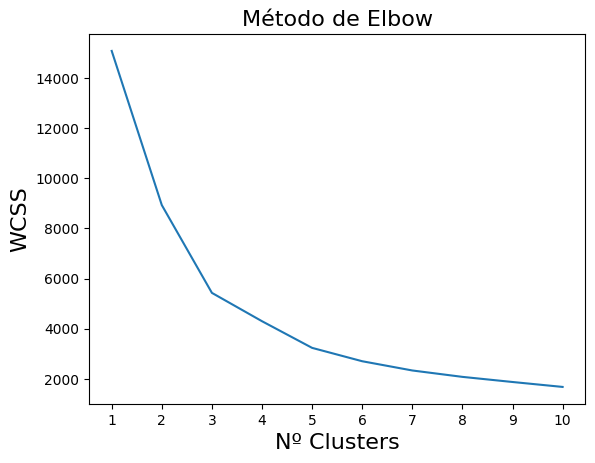

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SSE = {}
for i in range(1, 11, 1):
    clustering = KMeans(n_clusters=i, init='random', random_state=100).fit(df_cluster_scaled)
    inertia = clustering.inertia_  # inertia is the sum of squared distances of samples to their closest cluster center
    SSE[i] = inertia

plt.figure()
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

Now we chose the number of clusters we want to used based of elbow chart. 5 seems to be a good number since untill from 1 to 5 we reach a considerable decrease in the average distance between each sample and its cluster center

In [29]:
clustering = KMeans(n_clusters=5, init='random', random_state=100).fit(df_cluster_scaled)

clustering.labels_

array([3, 3, 1, ..., 2, 3, 3], dtype=int32)

In [30]:
df_cluster_scaled['cluster'] = clustering.labels_
df_cluster_scaled['cluster'] = df_cluster_scaled['cluster'].astype('category')  
df_clusterization['cluster'] = clustering.labels_
df_clusterization['cluster'] = df_clusterization['cluster'].astype('category') # Important so that the labels arent viewed as foats
df['cluster'] = clustering.labels_
df['cluster'] = df['cluster'].astype('category')  # Incororates the labes in the original dataframe
df_cluster_scaled.head()

C:\Users\Gabriel Bonanato\AppData\Local\Temp\ipykernel_26108\1624930724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusterization['cluster'] = clustering.labels_
C:\Users\Gabriel Bonanato\AppData\Local\Temp\ipykernel_26108\1624930724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusterization['cluster'] = df_clusterization['cluster'].astype('category') # Important so that the labels arent viewed as foats


,Age,FamilySize,cluster
0,-1.295683,0.755646,3
1,-0.332535,0.101152,3
2,1.413169,-1.207835,1
3,1.413169,-0.553341,1
4,-0.212142,2.064632,0


In [31]:
df_clusterization[['Age', 'FamilySize', 'cluster']].groupby(by=['cluster']).mean()

C:\Users\Gabriel Bonanato\AppData\Local\Temp\ipykernel_26108\1306282934.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clusterization[['Age', 'FamilySize', 'cluster']].groupby(by=['cluster']).mean()


,Age,FamilySize
cluster,,
0,30.911765,5.870844
1,70.043575,1.790990
2,38.561439,1.592158
3,28.436681,3.435434
4,51.387170,3.763774


Now we run a ANOVA test to see if there are significant changes in the mean values for each variables across clusters. This gives an idea of weather or not a variables was relevant for creating the cluster.

In [32]:
from scipy.stats import f_oneway

anova_results = []

for var in ['Age', 'FamilySize']:
    # Extract data for each cluster
    clusters_data = [df_cluster_scaled[var][df_cluster_scaled['cluster'] == i] for i in df_cluster_scaled['cluster'].unique()]
    
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*clusters_data)
    
    # Store the results
    anova_results.append({'Variable': var, 'F-statistic': f_statistic, 'p-value': p_value})

# Display ANOVA results
anova_results_df = pd.DataFrame(anova_results)
print("ANOVA Results:")
print(anova_results_df)

ANOVA Results:
     Variable  F-statistic  p-value
0         Age  6020.925602      0.0
1  FamilySize  7948.068021      0.0


Since p-values were below 5% for both variables, it means that both variables vary significantly across clusters and were relevant for creation of each of the clusters.

Now we create a qualitative database for running correspondency analysis.

In [33]:
df.columns

Index(['Gender', 'EverMarried', 'Age', 'Graduated', 'SpendingScore',
       'FamilySize', 'cluster'],
      dtype='object')

In [34]:
df_quali = df[['Gender', 'EverMarried', 'Graduated', 'SpendingScore', 'cluster']] 
df_quali.head()

,Gender,EverMarried,Graduated,SpendingScore,cluster
0,Male,No,No,Low,3
1,Female,Yes,Yes,Average,3
2,Female,Yes,Yes,Low,1
3,Male,Yes,Yes,High,1
4,Female,Yes,Yes,High,0


In [35]:
df_quali.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7538 entries, 0 to 8067
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Gender         7538 non-null   object  
 1   EverMarried    7538 non-null   object  
 2   Graduated      7538 non-null   object  
 3   SpendingScore  7538 non-null   object  
 4   cluster        7538 non-null   category
dtypes: category(1), object(4)
memory usage: 302.0+ KB


In [36]:
print(df_quali.Gender.value_counts())
print(df_quali.EverMarried.value_counts())
print(df_quali.Graduated.value_counts())
print(df_quali.SpendingScore.value_counts())
print(df_quali.cluster.value_counts())

Gender
Male      4163
Female    3375
Name: count, dtype: int64
EverMarried
Yes    4466
No     3072
Name: count, dtype: int64
Graduated
Yes    4731
No     2807
Name: count, dtype: int64
SpendingScore
Low        4504
Average    1888
High       1146
Name: count, dtype: int64
cluster
2    2474
3    1603
1    1354
4    1325
0     782
Name: count, dtype: int64


Now we want to verify weather or not the categorical variables correlate. To make it simpler, not all pairs of variables will be checked for correlation, but only the pairs containing the variable SpendingScore

In [37]:
other_vars = ['Gender', 'EverMarried', 'Graduated', 'cluster']

In [38]:
from scipy.stats import chi2_contingency

for var in other_vars:
    df_quali_cross_tab = pd.crosstab(df_quali['SpendingScore'], df_quali[var])
    chi_test =  chi2_contingency(df_quali_cross_tab)
    print('SpendingScore x', var)
    print(f"estatística qui²: {round(chi_test[0], 2)}")
    print(f"p-valor da estatística: {round(chi_test[1], 4)}")
    print('\n')

SpendingScore x Gender
estatística qui²: 29.58
p-valor da estatística: 0.0


SpendingScore x EverMarried
estatística qui²: 3492.82
p-valor da estatística: 0.0


SpendingScore x Graduated
estatística qui²: 181.99
p-valor da estatística: 0.0


SpendingScore x cluster
estatística qui²: 1968.56
p-valor da estatística: 0.0




In [42]:
from prince import MCA

mca = MCA(n_components=3).fit(df_quali)
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.442,24.55%,24.55%
1,0.270,15.00%,39.55%
2,0.238,13.21%,52.76%


In [43]:
import numpy as np
import plotly.express as px 

# Getting standard coordinates of variables categories

coord_padrao = mca.column_coordinates(df_quali)/np.sqrt(mca.eigenvalues_)
print(coord_padrao)

# Ploting perceptual map (standard coordinates)



chart = coord_padrao.reset_index()
var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])

nome_categ=[]
for col in df_quali:
    nome_categ.append(df_quali[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'obs_z': chart[2],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

# Segundo passo: gerar o gráfico de pontos

fig = px.scatter_3d(chart_df_mca, 
                    x='obs_x', 
                    y='obs_y', 
                    z='obs_z',
                    color='variavel',
                    text=chart_df_mca.categoria_id)
fig.show()


                              0         1         2
Gender_Female         -0.236523 -0.653927 -0.737880
Gender_Male            0.191753  0.530147  0.598209
EverMarried_No        -1.601284 -0.162705 -0.041124
EverMarried_Yes        1.101465  0.111919  0.028288
Graduated_No          -0.763391  1.381075  0.861258
Graduated_Yes          0.452936 -0.819420 -0.511002
SpendingScore_Average  1.424467 -1.121419  1.835795
SpendingScore_High     1.610741  2.433804 -1.707910
SpendingScore_Low     -1.006950 -0.149178 -0.334973
cluster_0             -1.224921  1.311033  1.123103
cluster_1              1.163937  1.913665 -2.508373
cluster_2             -0.259283 -1.936697 -0.950453
cluster_3             -1.387804  0.956657  1.135373
cluster_4              1.696630 -0.270539  2.301501
